In [1]:
import os
import pickle
import re
import sys
from glob import glob

import climlab
import fedrl_climate_envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs"

NUM_STEPS = 200

sys.path.append(BASE_DIR)

In [3]:
fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

climlab_ebm = climlab.EBM_annual(
    A=210, B=2, D=0.6, a0=0.354, a2=0.25, num_lat=96
)
climlab_ebm.Ts[:] = 50.0
Ts_ncep_annual = Ts_ncep_annual.interp(
    lat=climlab_ebm.lat, kwargs={"fill_value": "extrapolate"}
)
Ts_ncep_annual = np.array(Ts_ncep_annual)

for i in range(NUM_STEPS):
    climlab_ebm.step_forward()

Loading NCEP surface temperature data ...


In [4]:
def get_error_row(record_fn):
    with open(record_fn, "rb") as f:
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        ebm_state = record_steps["next_obs"][-1]
        error = Ts_ncep_annual - ebm_state

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "error": error,
            "fn": record_fn,
        }


def get_fedRL_error_rows(record_fns, ebm_sublatitudes):
    rows = {}
    for record_fn in record_fns:
        with open(record_fn, "rb") as f:
            exp_id, algo = record_fn.split("/")[-3:-1]
            exp_id = exp_id.split("_")[1]
            seed, cid = [int(x) for x in algo.split("__")[-3:-1]]
            algo = algo.split("__")[1].split("_")[1]
            ebm_min_idx, ebm_max_idx = (
                cid * ebm_sublatitudes,
                (cid + 1) * ebm_sublatitudes,
            )
            lat = climlab_ebm.lat[ebm_min_idx:ebm_max_idx]

            record_steps = torch.load(f)
            ebm_state = record_steps["next_obs"][-1]
            error = Ts_ncep_annual[ebm_min_idx:ebm_max_idx] - ebm_state

            row = {
                "exp_id": exp_id,
                "algo": algo,
                "seed": seed,
                "cid": cid,
                "error": error,
                "fn": record_fn,
                "lat": lat,
            }

            rows[cid] = row
    return rows

In [5]:
from collections import defaultdict


def get_algo_records(optim_group, algo):
    record_fns = sorted(
        glob(
            RECORDS_DIR
            + f"/infx10_*{optim_group}_*/*_{algo}_torch__*__*/*_{NUM_STEPS}.pth"
        )
    )
    records = defaultdict(dict)
    for record_fn in record_fns:
        error_row = get_error_row(record_fn)
        algo = error_row["algo"].lower()
        seed = int(error_row["seed"])
        error = error_row["error"]
        records[algo][seed] = error
    return records


def get_fedRL_algo_records(exp_id_main, algo, infxG=False):
    fedRL_algo_records = defaultdict(dict)
    stubs = ["fed05", "fed10"]
    if not infxG:
        stubs += ["nofed"]
    for stub in stubs:
        exp_id = exp_id_main + "-" + stub
        num_clients = int(re.search(r"-(?:a|c|ac)(\d+)-", exp_id).group(1))
        ebm_sublatitudes = EBM_LATITUDES // num_clients
        seeds = [x for x in range(1, 11)]
        records = defaultdict(dict)
        for seed in seeds:
            if infxG:
                record_fns = sorted(
                    glob(
                        RECORDS_DIR
                        + f"/infxG_*{exp_id}_*/*_{algo}_torch__{seed}__*__*/*_{NUM_STEPS}.pth"
                    )
                )
            else:
                record_fns = sorted(
                    glob(
                        RECORDS_DIR
                        + f"/infx10_*{exp_id}_*/*_{algo}_torch__{seed}__*__*/*_{NUM_STEPS}.pth"
                    )
                )
            records[seed] = get_fedRL_error_rows(record_fns, ebm_sublatitudes)
        fedRL_algo_records[stub] = records
    return fedRL_algo_records

In [6]:
def area_weighted_rmse(error, latitudes):
    weights = np.cos(np.radians(latitudes))
    weights /= weights.sum()
    return np.sqrt(np.average(error**2, weights=weights))


def plot_zonal_errors(
    fedRL_algo_records, nonfedRL_algo_records, algo, exp_id_main, infxG=False
):
    regimes = ["fed05", "fed10"]
    if not infxG:
        regimes += ["nofed"]
    bins = [-90, -60, -30, 0, 30, 60, 90]
    labels = [
        "90°S–60°S",
        "60°S–30°S",
        "30°S–0°",
        "0°–30°N",
        "30°N–60°N",
        "60°N–90°N",
    ]

    x = np.arange(len(labels))
    width = 0.175

    offsets = {
        "fed05": -width * 1.5,
        "fed10": -width * 0.5,
        "nofed": width * 0.5,
    }

    ebm_sublatitudes = EBM_LATITUDES // len(labels)

    # 1. climlab EBM
    error_climlab = Ts_ncep_annual - np.array(climlab_ebm.Ts).reshape(-1)
    climlab_means = []
    for i in range(len(bins) - 1):
        idx = (climlab_ebm.lat >= bins[i]) & (climlab_ebm.lat < bins[i + 1])
        climlab_means.append(
            area_weighted_rmse(error_climlab[idx], climlab_ebm.lat[idx])
        )

    plt.figure(figsize=(6.4, 4.8))
    plt.bar(
        x + width * (2.5 if not infxG else 1.5),
        climlab_means,
        width,
        label="CLIMLAB",
        color="gray",
        alpha=0.6,
    )

    # 2. ebm-v3 (fedRL regimes)
    for regime in regimes:
        seeds = fedRL_records[algo][regime].keys()
        num_clients = len(fedRL_records[algo][regime][1].keys())
        zone_errors = []

        for seed in seeds:
            errors = []
            for cid in range(num_clients):
                errors.append(fedRL_algo_records[regime][seed][cid]["error"])
            errors = np.array(errors).reshape(-1)

            zonal_means = []
            for i in range(len(bins) - 1):
                idx = (climlab_ebm.lat >= bins[i]) & (
                    climlab_ebm.lat < bins[i + 1]
                )
                zonal_means.append(
                    area_weighted_rmse(errors[idx], climlab_ebm.lat[idx])
                )
            zone_errors.append(zonal_means)

        zone_errors = np.array(zone_errors)
        means = zone_errors.mean(axis=0)
        stds = zone_errors.std(axis=0)
        best = zone_errors.min(axis=0)

        x_pos = x + offsets[regime]
        plt.bar(
            x_pos,
            means,
            width,
            label=f"{regime.upper()}" + ("" if not infxG else " - GLOBAL"),
            yerr=stds,
            capsize=4,
            alpha=0.8,
        )

        for i in range(len(x)):
            plt.hlines(
                y=best[i],
                xmin=x_pos[i] - width / 2,
                xmax=x_pos[i] + width / 2,
                colors="white",
                linestyles="solid",
                linewidth=1,
                zorder=1,
            )
            plt.plot(
                x_pos[i],
                best[i],
                marker="x",
                color="black",
                markersize=4,
                zorder=5,
            )

    # 3. ebm-v1 (single RL agent)
    for algo, seeds in nonfedRL_algo_records.items():
        zone_errors = []

        for seed, errors in seeds.items():
            zonal_means = []
            for i in range(len(bins) - 1):
                idx = (climlab_ebm.lat >= bins[i]) & (
                    climlab_ebm.lat < bins[i + 1]
                )
                zonal_means.append(
                    area_weighted_rmse(errors[idx], climlab_ebm.lat[idx])
                )
            zone_errors.append(zonal_means)

        zone_errors = np.array(zone_errors)
        mean = zone_errors.mean(axis=0)
        std = zone_errors.std(axis=0)
        best = zone_errors.min(axis=0)

        x_pos = x + width * (1.5 if not infxG else 0.5)
        bars = plt.bar(
            x_pos,
            mean,
            width,
            label=f"EBM-v1",
            yerr=std,
            capsize=3,
            alpha=0.8,
            color="#d62728",
        )

        for i in range(len(x)):
            plt.hlines(
                y=best[i],
                xmin=x_pos[i] - width / 2,
                xmax=x_pos[i] + width / 2,
                colors="white",
                linestyles="solid",
                linewidth=1,
                zorder=1,
            )
            plt.plot(
                x_pos[i],
                best[i],
                marker="x",
                color="black",
                markersize=4,
                zorder=5,
            )

    plt.xticks(x, labels)
    plt.title(f"{algo.upper()} | {exp_id_main}")
    plt.xlabel("Latitude")
    plt.ylabel("Area Weighted RMSE (°C)")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.ylim(bottom=0)
    plt.tight_layout()

    img_fn = (
        f"{IMGS_DIR}/{exp_id_main}_{algo}"
        + ("" if not infxG else "_global")
        + "_areaWRMSE_zonal_errors.png"
    )
    plt.savefig(
        img_fn,
        dpi=300,
        bbox_inches="tight",
    )

In [7]:
EBM_LATITUDES = 96
ALGOS = ["ddpg", "td3", "tqc"]

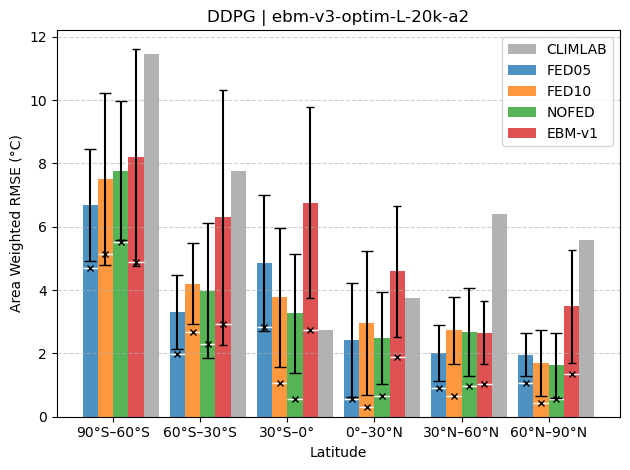

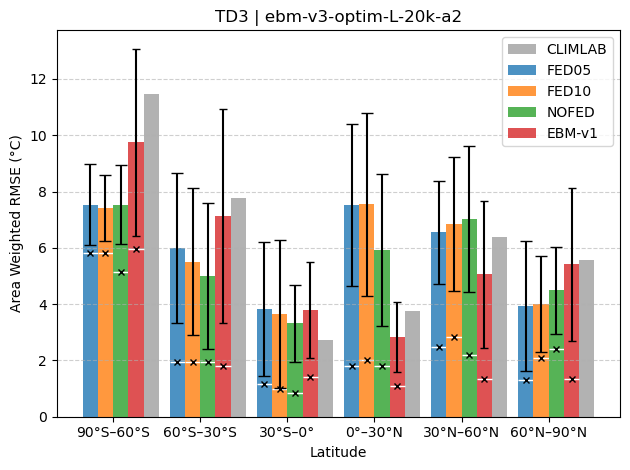

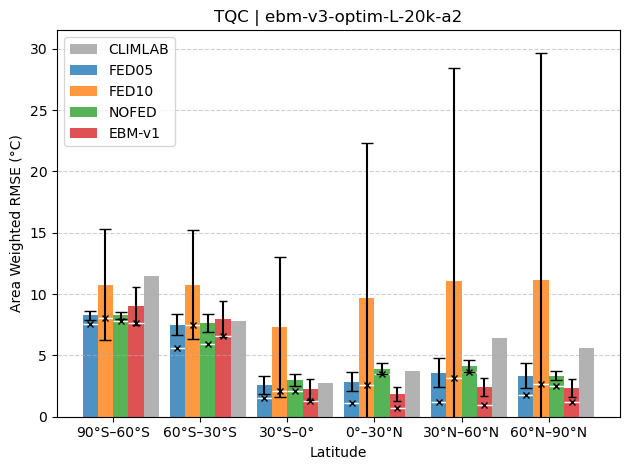

In [8]:
EXPERIMENT_ID_MAIN = "ebm-v3-optim-L-20k-a2"
OPTIM_GROUP = "ebm-v1-optim-L-20k"

nonfedRL_records, fedRL_records = {}, {}
for algo in ALGOS:
    fedRL_algo_records = get_fedRL_algo_records(EXPERIMENT_ID_MAIN, algo)
    nonfedRL_algo_records = get_algo_records(OPTIM_GROUP, algo)
    nonfedRL_records[algo], fedRL_records[algo] = (
        nonfedRL_algo_records,
        fedRL_algo_records,
    )

for algo in ALGOS:
    plot_zonal_errors(
        fedRL_records[algo], nonfedRL_records[algo], algo, EXPERIMENT_ID_MAIN
    )

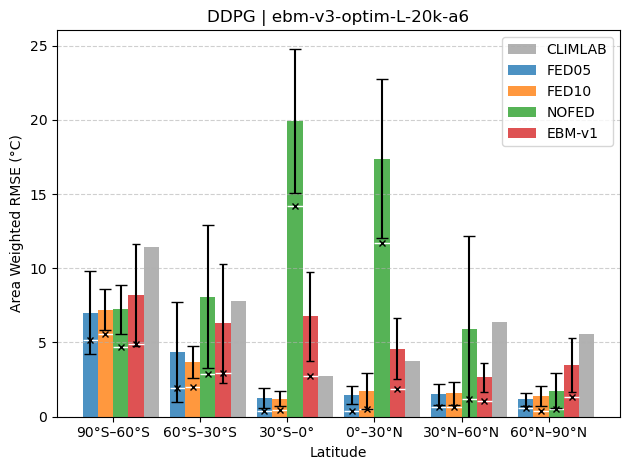

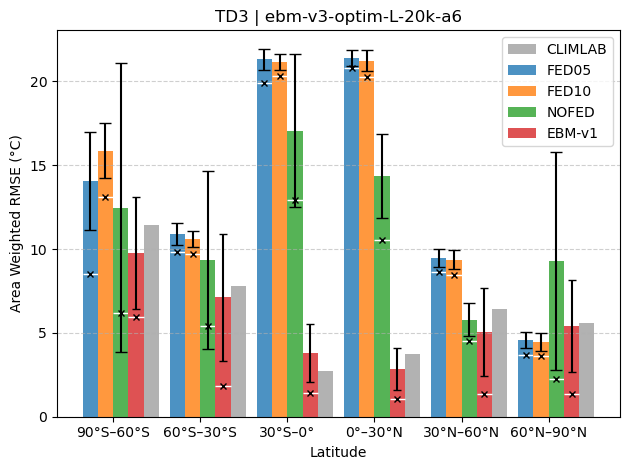

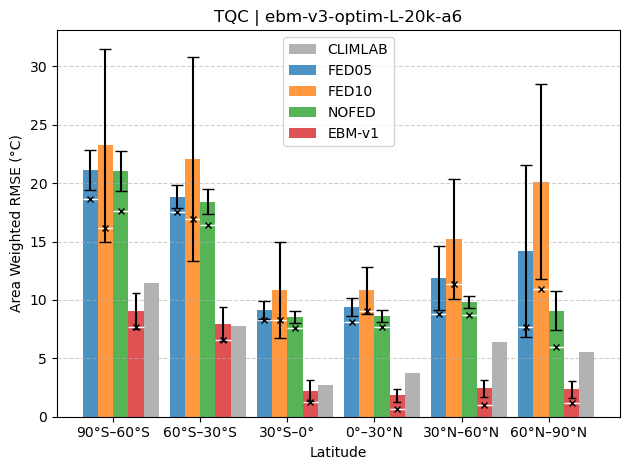

In [9]:
EXPERIMENT_ID_MAIN = "ebm-v3-optim-L-20k-a6"
OPTIM_GROUP = "ebm-v1-optim-L-20k"

nonfedRL_records, fedRL_records = {}, {}
for algo in ALGOS:
    fedRL_algo_records = get_fedRL_algo_records(EXPERIMENT_ID_MAIN, algo)
    nonfedRL_algo_records = get_algo_records(OPTIM_GROUP, algo)
    nonfedRL_records[algo], fedRL_records[algo] = (
        nonfedRL_algo_records,
        fedRL_algo_records,
    )

for algo in ALGOS:
    plot_zonal_errors(
        fedRL_records[algo], nonfedRL_records[algo], algo, EXPERIMENT_ID_MAIN
    )

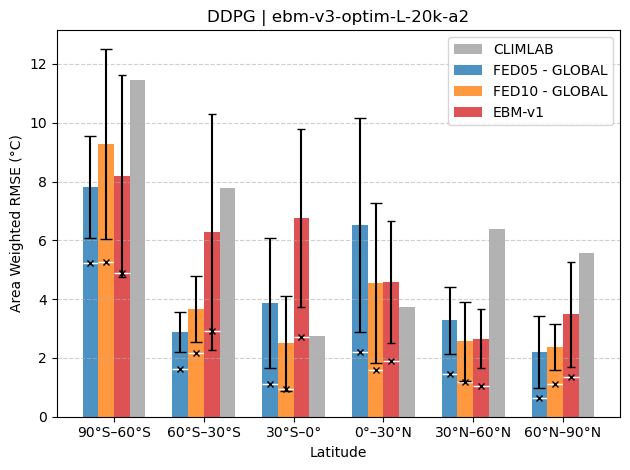

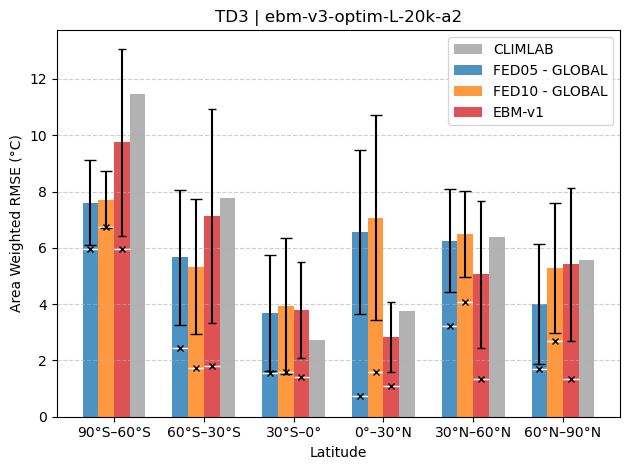

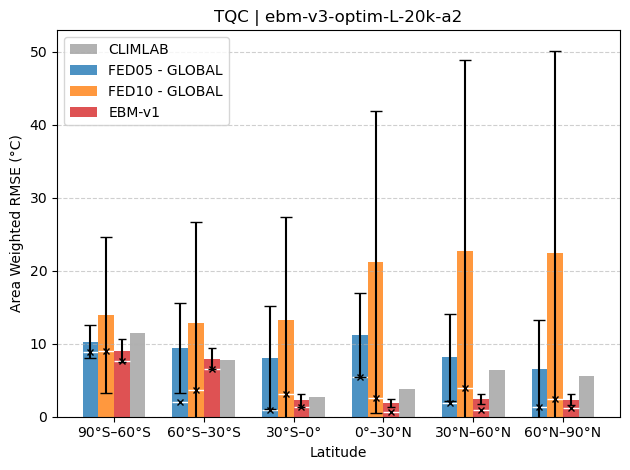

In [10]:
EXPERIMENT_ID_MAIN = "ebm-v3-optim-L-20k-a2"
OPTIM_GROUP = "ebm-v1-optim-L-20k"

nonfedRL_records, fedRL_records = {}, {}
for algo in ALGOS:
    fedRL_algo_records = get_fedRL_algo_records(
        EXPERIMENT_ID_MAIN, algo, infxG=True
    )
    nonfedRL_algo_records = get_algo_records(OPTIM_GROUP, algo)
    nonfedRL_records[algo], fedRL_records[algo] = (
        nonfedRL_algo_records,
        fedRL_algo_records,
    )

for algo in ALGOS:
    plot_zonal_errors(
        fedRL_records[algo],
        nonfedRL_records[algo],
        algo,
        EXPERIMENT_ID_MAIN,
        infxG=True,
    )

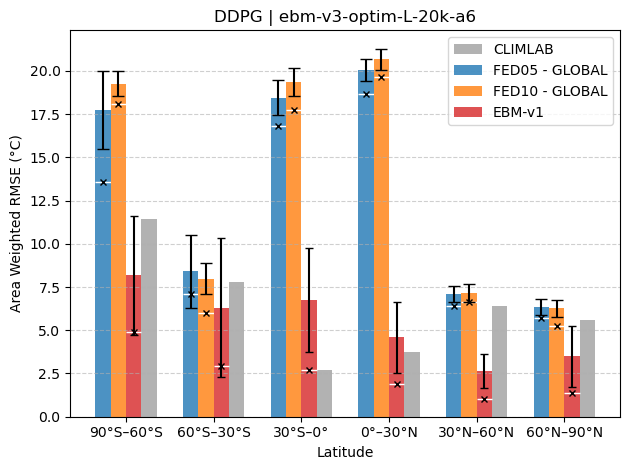

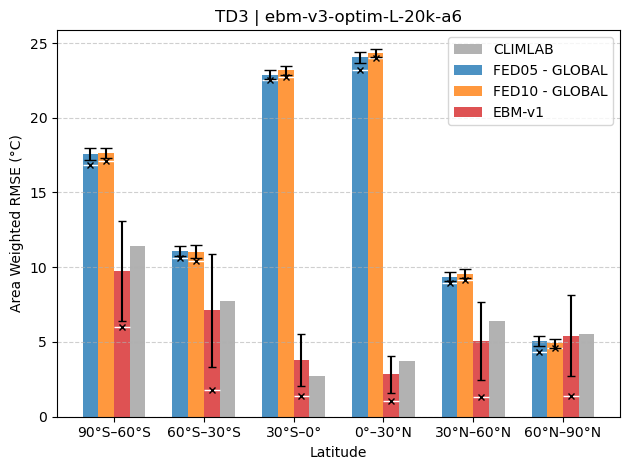

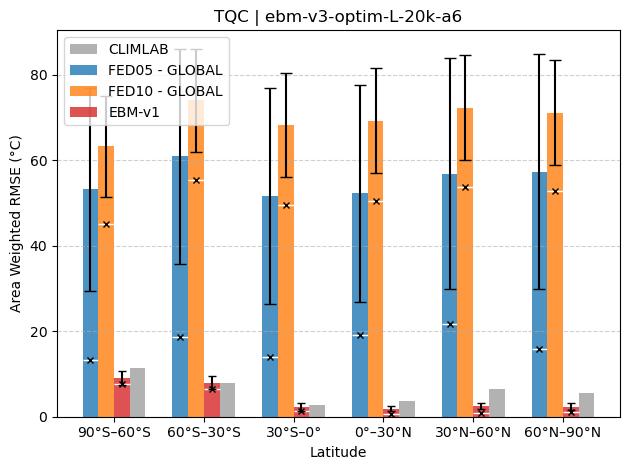

In [11]:
EXPERIMENT_ID_MAIN = "ebm-v3-optim-L-20k-a6"
OPTIM_GROUP = "ebm-v1-optim-L-20k"

nonfedRL_records, fedRL_records = {}, {}
for algo in ALGOS:
    fedRL_algo_records = get_fedRL_algo_records(
        EXPERIMENT_ID_MAIN, algo, infxG=True
    )
    nonfedRL_algo_records = get_algo_records(OPTIM_GROUP, algo)
    nonfedRL_records[algo], fedRL_records[algo] = (
        nonfedRL_algo_records,
        fedRL_algo_records,
    )

for algo in ALGOS:
    plot_zonal_errors(
        fedRL_records[algo],
        nonfedRL_records[algo],
        algo,
        EXPERIMENT_ID_MAIN,
        infxG=True,
    )